# Kuzushiji Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for image classification. We will use a variant of the famous MNIST dataset (the original is a dataset of handwritten digits). The version we are going to use is called Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) and is a dataset of traditional japanese handwritten kana.



The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

## TODO: Insert your surname, name and ID number

Student surname: Zomer

Student name: Nicola 
    
ID: 2058479

In [1]:
#load the required packages

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import sklearn.metrics as skm

In [2]:
# helper function to load Kuzushiji-MNIST dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

In [3]:
#fix your ID ("numero di matricola") and the seed for random generator (as usual you can try different seeds)
ID = 2058479
np.random.seed(ID)

In [4]:
#load the K-MNIST dataset from the 'data' folder and let's normalize the features so that each value is in [0,1] 

X, y = load_mnist('data', kind='train')
# rescale the data
X, y = X / 255., y # original pixel values are between 0 and 255
print(X.shape, y.shape)
print(X.dtype, y.dtype)

# 60000 samples, each featuring 784 pixels

(60000, 784) (60000,)
float64 uint8


Now split into training and test. Make sure that each label is present at least 10 times
in training. If it is not, then keep adding permutations to the initial data until this 
happens.

In [5]:
# FUNCTION FOR CHECKING IF EACH UNIQUE LABEL APPEARS IN THE ARRAY A MINIMUM NUMBER OF TIMES

def check_minimum_labels(Y, minimum):
    # Y has to be a np array
    labels = np.unique(Y)
    for label in labels:
        if np.sum(Y==label) < minimum:
            return False
    return True   

In [6]:
# Random permute the data and split into training and test taking the first 
# 600 data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

# we don't use the whole dataset
m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

while not check_minimum_labels(y_train, 10):
    permutation = np.random.permutation(X.shape[0]) # again random permutation
    
    X = X[permutation]
    y = y[permutation]
    
    X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
    y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

labels, freqs = np.unique(y_train, return_counts=True)
# If 'return_counts' is True, also return the number of times each unique item appears in the array
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [61 47 58 73 67 59 59 66 56 54]


In [7]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("LABEL: %i"%labels[index])
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    return

LABEL: 0
INPUT:


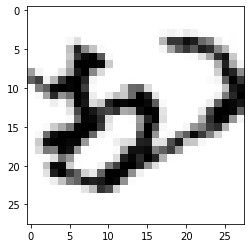

LABEL: 0
INPUT:


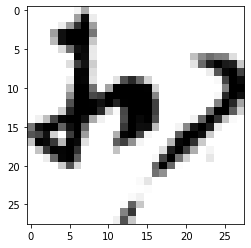

LABEL: 0
INPUT:


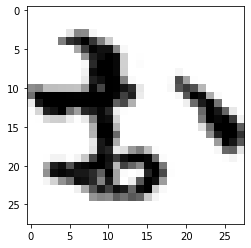

LABEL: 9
INPUT:


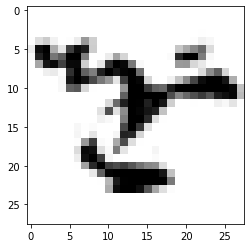

In [8]:
#let's try the plotting function
plot_input(X_train,y_train,5)
plot_input(X_test,y_test,50)
plot_input(X_test,y_test,500)
plot_input(X_test,y_test,700)

## TO DO 1
Use a SVM classifier with cross validation to pick a model. Use a **4-fold cross-validation**. Let's start with a Linear kernel:

In [9]:
#import SVC
from sklearn.svm import SVC
#import for Cross-vcValidation
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [10]:
# parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1, 10]}

# train linear SVM
svc = SVC(kernel = 'linear')
lin_model = GridSearchCV(svc, parameters)
results_linear = lin_model.fit(X_train, y_train)

print ('RESULTS FOR LINEAR KERNEL')
print("Best parameters set found:")
print(results_linear.best_params_)

print("Score with best parameters:")
print(results_linear.best_score_)

print("\nAll scores on the grid:")
print(results_linear.cv_results_['mean_test_score'])

RESULTS FOR LINEAR KERNEL
Best parameters set found:
{'C': 1}
Score with best parameters:
0.7616666666666667

All scores on the grid:
[0.73666667 0.76       0.76166667 0.76166667]


## TO DO 2
Pick a model for the Polynomial kernel with degree=2:

In [11]:
# parameters for poly with degree 2 kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1]}

# run SVM with poly of degree 2 kernel

svc = SVC(kernel = 'poly', degree = 2)
deg2_model = GridSearchCV(svc, parameters)
results_deg2 = deg2_model.fit(X_train, y_train)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')
print("Best parameters set found:")
print(results_deg2.best_params_)

print("Score with best parameters:")
print(results_deg2.best_score_)

print("\nAll scores on the grid:")
params_comb = results_deg2.cv_results_['params']
mean_scores = results_deg2.cv_results_['mean_test_score']

df = pd.DataFrame({'C': [x['C'] for x in params_comb], 'gamma': [x['gamma'] for x in params_comb], 'mean score': mean_scores})
df
# print(df.to_string(index=False))


RESULTS FOR POLY DEGREE=2 KERNEL
Best parameters set found:
{'C': 0.1, 'gamma': 0.1}
Score with best parameters:
0.7916666666666667

All scores on the grid:


,C,gamma,mean score
0,0.01,0.01,0.121667
1,0.01,0.10,0.768333
2,0.01,1.00,0.786667
3,0.10,0.01,0.536667
4,0.10,0.10,0.791667
5,0.10,1.00,0.786667
6,1.00,0.01,0.768333
7,1.00,0.10,0.786667
8,1.00,1.00,0.786667


## TO DO 3

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

In [12]:
# parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1]}

#run SVM with poly of higher degree kernel
deg = 3

svc = SVC(kernel = 'poly', degree=deg)
deg3_model = GridSearchCV(svc, parameters)
results_deg3 = deg3_model.fit(X_train, y_train)

print ('RESULTS FOR POLY DEGREE=', deg, ' KERNEL')
print("Best parameters set found:")
print(results_deg3.best_params_)

print("Score with best parameters:")
print(results_deg3.best_score_)

print("\nAll scores on the grid:")
params_comb = results_deg3.cv_results_['params']
mean_scores = results_deg3.cv_results_['mean_test_score']

df = pd.DataFrame({'C': [x['C'] for x in params_comb], 'gamma': [x['gamma'] for x in params_comb], 'mean score': mean_scores})
df

# ADD YOUR CODE

RESULTS FOR POLY DEGREE= 3  KERNEL
Best parameters set found:
{'C': 0.01, 'gamma': 0.1}
Score with best parameters:
0.7533333333333332

All scores on the grid:


,C,gamma,mean score
0,0.01,0.01,0.121667
1,0.01,0.10,0.753333
2,0.01,1.00,0.715000
3,0.10,0.01,0.425000
4,0.10,0.10,0.715000
5,0.10,1.00,0.715000
6,1.00,0.01,0.730000
7,1.00,0.10,0.715000
8,1.00,1.00,0.715000


## TO DO 4
Pick a model for the Radial Basis Function kernel:

In [13]:
# parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

#run SVM with rbf kernel

svc = SVC(kernel = 'rbf')
rbf_model = GridSearchCV(svc, parameters)
results_rbf = rbf_model.fit(X_train, y_train)

print ('RESULTS FOR rbf KERNEL')
print("Best parameters set found:")
print(results_rbf.best_params_)

print("Score with best parameters:")
print(results_rbf.best_score_)

print("\nAll scores on the grid:")
params_comb = results_rbf.cv_results_['params']
mean_scores = results_rbf.cv_results_['mean_test_score']

df = pd.DataFrame({'C': [x['C'] for x in params_comb], 'gamma': [x['gamma'] for x in params_comb], 'mean score': mean_scores})
df

RESULTS FOR rbf KERNEL
Best parameters set found:
{'C': 10, 'gamma': 0.01}
Score with best parameters:
0.8150000000000001

All scores on the grid:


,C,gamma,mean score
0,0.1,0.001,0.121667
1,0.1,0.010,0.178333
2,0.1,0.100,0.121667
3,0.1,1.000,0.121667
4,1.0,0.001,0.651667
5,1.0,0.010,0.778333
6,1.0,0.100,0.133333
7,1.0,1.000,0.121667
8,10.0,0.001,0.770000
9,10.0,0.010,0.815000


## QUESTION 1
What do you observe when using linear, polynomial and RBF kernels on this dataset ?

## TO DO 5
Report here the best SVM kernel and parameters

In [14]:
#get training and test error for the best SVM model from CV
models_print_list = ['linear', 'poly, degree 2', 'poly, degree 3', 'RBF']
kernels_list = ['linear', 'poly', 'poly', 'rbf']
degrees_list = {1: 2, 2: 3}
results_list = [results_linear, results_deg2, results_deg3, results_rbf]
index_best_SVM = np.argmax(np.array([results_list[i].best_score_ for i in range(4)]))
best_SVM = results_list[index_best_SVM]

print('Best SVM model:', models_print_list[index_best_SVM])

# (error is 1 - svm.score)
training_error = 1 - best_SVM.score(X_train, y_train)
test_error = 1 - best_SVM.score(X_test, y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM model: RBF
Best SVM training error: 0.000000
Best SVM test error: 0.173500


## TO DO 6

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [15]:
#Test with different values of gamma

# Set gamma values
gamma_values = np.logspace(-5,2,8)
print(gamma_values)


[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


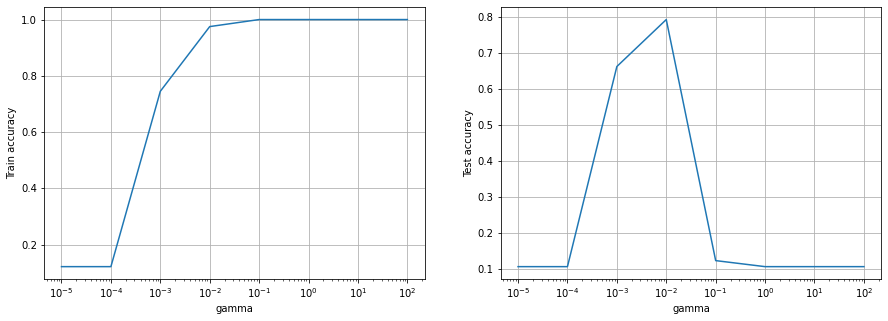

In [16]:
# Try the SVM with the previously set values of gamma
# use rbf kernel and C=1

train_acc_list, test_acc_list = [], []

# ADD YOUR CODE TO TRAIN THE SVM MULTIPLE TIMES WITH THE DIFFERENT VALUES OF GAMMA
# PLACE THE TRAIN AND TEST ACCURACY FOR EACH TEST IN THE TRAIN AND TEST ACCURACY LISTS
for gamma in gamma_values:
    model = SVC(kernel = 'rbf', C=1, gamma = gamma)
    model.fit(X_train, y_train)
    train_acc_list.append(model.score(X_train, y_train))
    test_acc_list.append(model.score(X_test, y_test))
    
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)


plt.show()

## QUESTION 2
How do the train and test error change when changing gamma ? Which is the best value of gamma ? 
Connect your answers to the discussion about the overfitting issue.

## More data
Now let's do the same but using more data points for training and all the remaining for testing. 


Choose a new number of data points.

In [17]:
X = X[permutation]
y = y[permutation]

m_training = 2000 # TODO number of data points, adjust depending on the capabilities of your PC

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [190 205 209 188 206 202 205 202 205 188]


## TO DO 7

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  2000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the cell below.

In [18]:
#get training and test error for the best SVM model from CV

best_param = best_SVM.best_params_
kern = kernels_list[index_best_SVM]
print('Kernel:', kern)
if kern == 'poly':
    bestSVM = SVC(kernel = kern, degree=degrees_list[index_best_SVM], C = best_param['C'], gamma = best_param['gamma'])
else:
    bestSVM = SVC(kernel = kern, C = best_param['C'], gamma = best_param['gamma'])
bestSVM.fit(X_train, y_train)
training_error = 1-bestSVM.score(X_train, y_train)
test_error = 1 - bestSVM.score(X_test, y_test)

print ("\nBest SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Kernel: rbf

Best SVM training error: 0.000000
Best SVM test error: 0.118966


Just for comparison, let's also use logistic regression 

## TO DO 8 Try first without regularization (use a very large large C)¶

In [19]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5, max_iter=1000)
logreg.fit(X_train, y_train)

training_error = 1-logreg.score(X_train, y_train)
test_error = 1 - logreg.score(X_test, y_test)

print ("Best logistic regression training error: %f" % training_error)
print ("Best logistic regression test error: %f" % test_error)

Best logistic regression training error: 0.000000
Best logistic regression test error: 0.282603


## TO DO 9 Try  with regularization (use C=1)¶

In [20]:
logreg = linear_model.LogisticRegression(C=1, max_iter=1000)
logreg.fit(X_train, y_train)

training_error = 1-logreg.score(X_train, y_train)
test_error = 1 - logreg.score(X_test, y_test)

print ("Best regularized logistic regression training error: %f" % training_error)
print ("Best regularized logistic regression test error: %f" % test_error)

Best regularized logistic regression training error: 0.002500
Best regularized logistic regression test error: 0.256259


## QUESTION 3
Compare and discuss:
- the results from SVM with m=600 and with m=2000 training data points. If you stopped the SVM, include such aspect in your comparison.
- the results of SVM and of Logistic Regression

## TO DO 10
Plot an item of clothing that is missclassified by logistic regression and correctly classified by SVM.

LABEL: 6
INPUT:


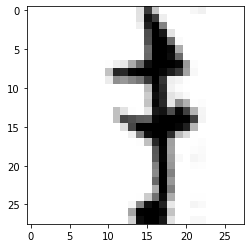

SVM prediction: 6
LR prediction: 2


In [43]:
for sample, label, i in zip(X, y, range(X.shape[0])):
    if bestSVM.predict(sample.reshape(1, -1)) == label and logreg.predict(sample.reshape(1, -1)) != label:
            LR_prediction = logreg.predict(sample.reshape(1, -1))[0]
            SVM_prediction = label
            x_missclassified = sample
            index = i
            break

plot_input(X, y, index)
print('SVM prediction:', SVM_prediction)
print('LR prediction:', LR_prediction)

## TO DO 11
Plot the confusion matrix for the SVM classifier and for logistic regression.
The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label.
Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors.
You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation).
Try also to normalize the confusion matrix by the number of samples in each class in order to measure the accuracy on each single class.


In [ ]:
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_SVM = # ADD CODE
print("\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

confusion_LR =  # ADD CODE
print("\n Confusion matrix LR  \n \n", confusion_LR)
print("\n Confusion matrix LR (normalized)   \n \n", confusion_LR /counts[:,None] )

In [ ]:
# ADD CODE TO NORMALIZE CONFUSION MATRIX AND PRINT THE NORMALIZED MATRIX


## QUESTION 4
Have a look at the confusion matrices and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one ? Make some guesses on the possible causes.
